**Toxic Comment Classification Assessment**

**The Jigsaw Toxic Comment** Classification dataset is a collection of Wikipedia talk page comments, labeled for various types of toxicity (toxic, severe_toxic, obscene, threat, insult, identity_hate). The goal of this task is to build a safety model capable of flagging abusive content.

The labels are originally multi-label (a comment can be both an insult and a threat). For this project i want just to generalise and know if its abusive or safe , we aggregate these into a Binary Classification task: Safe (0) vs. Abusive (1). This focuses the model on the detection of general malicious intent, which is critical for content moderation systems.

link to model : https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

In [1]:
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd #we will use pandas to view data in dataframes
import numpy as np #we will use numpy for numerical operations
import re #regular expressions for text cleaning
import string #string operations
import torch    #we will use pytorch for building our model
from sklearn.model_selection import train_test_split #to split data into train and validation sets

# Load Data
try:
    df = pd.read_csv('data/train.csv', nrows=50000) # Using 50k subset for dev
    print(f"Data Loaded: {len(df)} rows")
except:
    print("Error loading data")   # Handle file not found or read errors

# Pivot to Binary Target
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['is_abusive'] = df[label_cols].max(axis=1) # Create binary target column

x = df['comment_text'] # Features
y = df['is_abusive'] # Target

print(f"Sample Text: {x[0]}")  # Display a sample text
print(f"Label: {y[0]}")  # Display the corresponding label

Data Loaded: 50000 rows
Sample Text: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Label: 0


Section 1 - Preprocessing
Text data from social media is inherently noisy, containing non-standard grammar, punctuation, and mixed casing. Preprocessing is required to standardize the input space before representation learning.

For this pipeline, we define a clean_text function that performs:

Lowercasing: Standardizes "Hello" and "hello".

Noise Removal: Removes punctuation and special characters using Regex.

Artifact Removal: Strips wiki-style formatting (e.g., [USER]).

In [2]:
def prep(text_series):
    cleaned_text = []
    for text in text_series:
        text = str(text).lower()
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\w*\d\w*', '', text)
        cleaned_text.append(text)
    return cleaned_text

# Apply Preprocessing
prep_x = prep(x)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(prep_x, y, test_size=0.2, random_state=42)
print("Preprocessing Complete.")

Preprocessing Complete.


Section 2 - Representation Learning
Machine learning algorithms cannot process raw text; they require numerical input. This section compares two distinct approaches to representation learning:

1. Statistical: TF-IDF Term Frequency-Inverse Document Frequency (TF-IDF) creates a sparse vector representation. It operates on the "Bag-of-Words" assumption, treating words as independent features. It weighs terms by their rarity, assigning higher value to unique words (like "murder") and lower value to common words (like "the").

2. Contextual: Transformer Embeddings Unlike statistical methods, Deep Learning models like DistilBERT and RoBERTa learn dense vector representations. They utilize Self-Attention mechanisms to capture the context of a word based on its neighbors. This allows the model to distinguish between polysemous words (e.g., "kill time" vs. "kill you") and detect semantic nuances like sarcasm.

In [3]:
# We define the representation pipelines here
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer

# 1. Statistical Vectorizer Setup
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# 2. Deep Learning Tokenizer Setup
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def get_bert_encodings(texts):
    return bert_tokenizer(texts, padding="max_length", truncation=True, max_length=128)

print("Representation pipelines initialized.")

Representation pipelines initialized.


Section 3 - Algorithms
Logistic Regression (Baseline)
Logistic Regression is a linear classifier that estimates the probability of a binary outcome using the weighted sum of input features. It is chosen as a baseline due to its computational efficiency and interpretability. While effective for simple keyword-based detection, it typically struggles with non-linear relationships (e.g., "I am not happy" vs "I am happy").

DistilBERT (Deep Learning)
DistilBERT is a distilled version of the BERT (Bidirectional Encoder Representations from Transformers) architecture. It is a pre-trained language model that has "read" the entire English Wikipedia. By fine-tuning this model on our toxic dataset, we leverage its deep understanding of language structure (Transfer Learning) to detect subtle forms of abuse that do not rely on explicit keywords.

In [4]:
# --- Algorithm 1: Logistic Regression ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Create Representations
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Predict
lr_preds = lr_model.predict(X_test_tfidf)
print("Logistic Regression Trained.")

# --- Algorithm 2: DistilBERT ---
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Prepare Data
train_ds = Dataset.from_dict({'text': X_train, 'label': y_train})
test_ds = Dataset.from_dict({'text': X_test, 'label': y_test})
tokenized_train = train_ds.map(lambda x: get_bert_encodings(x['text']), batched=True)
tokenized_test = test_ds.map(lambda x: get_bert_encodings(x['text']), batched=True)

# Train
bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
training_args = TrainingArguments(output_dir='./results', num_train_epochs=1, fp16=True)

trainer = Trainer(model=bert_model, args=training_args, train_dataset=tokenized_train)
trainer.train()
print("DistilBERT Trained.")

Logistic Regression Trained.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.214700
1000,0.159200
1500,0.162300
2000,0.145500
2500,0.140700
3000,0.145200
3500,0.142700
4000,0.119200
4500,0.121300
5000,0.121400


DistilBERT Trained.


# Section 4 - Evaluation

To compare the effectiveness of the statistical (Logistic Regression) and deep learning (DistilBERT) approaches, we evaluate their performance on the held-out test set (20% of the data).

We utilize three key metrics:
1. **Accuracy:** The overall percentage of correct predictions.
2. **Recall:** The ability of the model to find *all* toxic comments (minimizing False Negatives).
3. **F1-Score:** The harmonic mean of Precision and Recall, useful for imbalanced datasets.

The hypothesis is that while Accuracy may be similar, the DistilBERT model will demonstrate superior **Recall** due to its contextual understanding.

🚀 Starting Evaluation...
   Getting Baseline Predictions...
   Getting Deep Learning Predictions (GPU)...



📊 RESULTS TABLE:
Metric          | LogReg (TF-IDF)      | DistilBERT          
------------------------------------------------------------
Accuracy        | 0.9407               | 0.9611
Recall          | 0.4928               | 0.7355
F1 Score        | 0.6472               | 0.8068


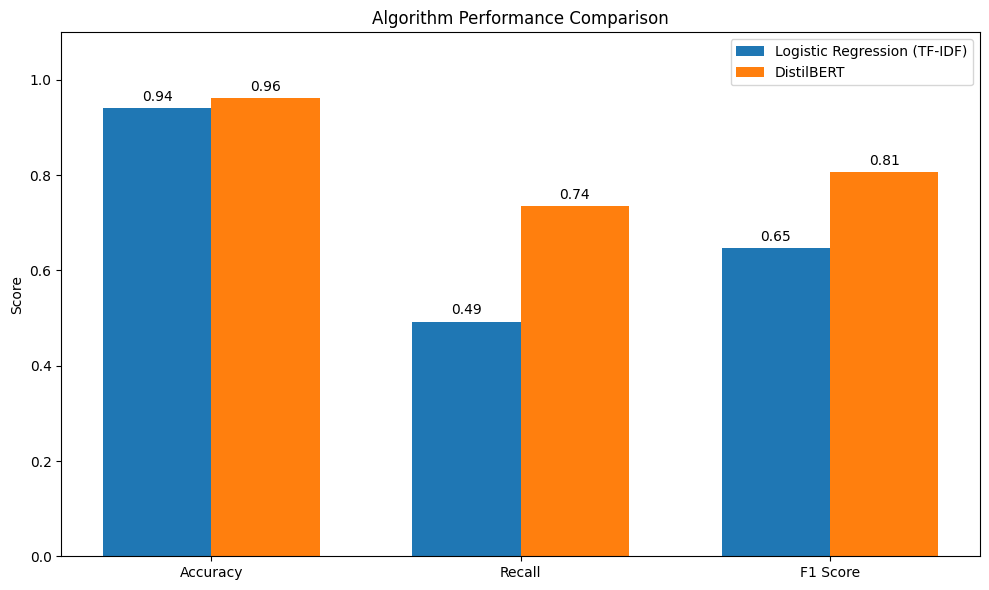

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score

print("🚀 Starting Evaluation...")

# --- 1. GET PREDICTIONS ---

# A. Logistic Regression (Baseline)
# We use the TF-IDF test data created in Section 3
print("   Getting Baseline Predictions...")
lr_preds = lr_model.predict(X_test_tfidf)

# B. DistilBERT (Deep Learning)
# We use the 'trainer' object from Section 3 to predict on the tokenized test set
print("   Getting Deep Learning Predictions (GPU)...")
bert_predictions_output = trainer.predict(tokenized_test)
# The trainer returns raw logits (scores), we need to pick the highest one (0 or 1)
bert_preds = np.argmax(bert_predictions_output.predictions, axis=1)

# --- 2. CALCULATE METRICS ---

# Helper function to calculate metrics dictionary
def get_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred)
    }

lr_metrics = get_metrics(y_test, lr_preds)
bert_metrics = get_metrics(y_test, bert_preds)

print("\n📊 RESULTS TABLE:")
print(f"{'Metric':<15} | {'LogReg (TF-IDF)':<20} | {'DistilBERT':<20}")
print("-" * 60)
print(f"{'Accuracy':<15} | {lr_metrics['Accuracy']:.4f}{'':<14} | {bert_metrics['Accuracy']:.4f}")
print(f"{'Recall':<15} | {lr_metrics['Recall']:.4f}{'':<14} | {bert_metrics['Recall']:.4f}")
print(f"{'F1 Score':<15} | {lr_metrics['F1']:.4f}{'':<14} | {bert_metrics['F1']:.4f}")

# --- 3. VISUALISATION (Grouped Bar Chart) ---

labels = ['Accuracy', 'Recall', 'F1 Score']
lr_scores = [lr_metrics['Accuracy'], lr_metrics['Recall'], lr_metrics['F1']]
bert_scores = [bert_metrics['Accuracy'], bert_metrics['Recall'], bert_metrics['F1']]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, lr_scores, width, label='Logistic Regression (TF-IDF)', color='#1f77b4')
rects2 = ax.bar(x + width/2, bert_scores, width, label='DistilBERT', color='#ff7f0e')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Algorithm Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.1) # Set y-limit to 1.1 to make room for labels

# Function to add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()